In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
carrier_freq = 800e6

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadar = RadarPulseGenerator(t, T=T, device=device)

radar_pulse = myRadar.LFM_pulse(B) * np.sqrt(1e4) #normalize power to unity (1Watt)
radar_pulse_power = myRadar.power_calc(radar_pulse)
print(10*np.log10(radar_pulse_power.cpu().numpy()))

N0 = 10**(-130/10)
print(10*np.log10(N0))
MN = int(2000)
distances = np.linspace(100,1000,10)
est_distances = torch.zeros((MN, len(distances)))
crlb_distances = torch.zeros(len(distances))
SNRs_db = torch.zeros(len(distances))
for idx, dis in enumerate(distances):
    # print((idx+1)/len(distances)*100)
    A = myRadar.LOS_pathloss(dis, carrier_freq, 3e8)
    # print(f'distance: {dis}m, Loss: {A}')
    est_distances[:, idx], _ = myRadar.montecarlo_estimation_with_real(radar_pulse, N0, dis, np.sqrt(A), 3e8, MN)
    crlb_distances[idx] = myRadar.LFM_delayCRLB_with_real(B, T, N0, A) * (3e8/2)**2 / 1e4 #devided by 1e4 because power normalized to unity
    SNRs_db[idx] = 10 * np.log10(A**2 / N0)
    print(f'Mean value->{torch.mean(est_distances[:, idx])}, \t Variance->{torch.var(est_distances[:, idx])}')
    print(f'True value->{dis}, \t CRLB->{crlb_distances[idx]}')

# --- Modified Plotting Section ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plotting on the primary (left) y-axis
ax1.set_title('CRLB and Estimation Variance vs. Distance and SNR', fontsize=16)
ax1.set_xlabel(r'Distance ($m$)', fontsize=12)
ax1.set_ylabel(r'Variance ($m^2$)', fontsize=12, color='b')
ax1.plot(distances, crlb_distances.numpy(), label='CRLB', marker='o', color='blue')
ax1.plot(distances, torch.var(est_distances, dim=0).cpu().numpy(), label='Estimation Variance', marker='x', linestyle='--', color='cyan')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(which='both', linestyle=':')

# Create the twin (right) y-axis
ax2 = ax1.twinx()
ax2.set_ylabel(r'SNR ($dB$)', fontsize=12, color='r')
ax2.plot(distances, SNRs_db, label='SNR', marker='s', linestyle='-.', color='red')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both axes into one box
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

fig.tight_layout()
plt.savefig("crlb_vs_distance_with_snr.pdf", bbox_inches='tight')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
carrier_freq = 800e6

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadar = RadarPulseGenerator(t, T=T, device=device)

radar_pulse = myRadar.LFM_pulse(B) * np.sqrt(1e4) #normalize power to unity (1Watt)

myData = np.load('results_data.npz')
# mySignal = myData['truesignal']
N0 = 10**(-114/10)
MN = int(2000)
distances = torch.linspace(100,1000,10)
SNRs_db = torch.zeros(len(distances))
crlb_distances = torch.zeros(len(distances))
for idx, dis in enumerate(distances):
    A = myRadar.LOS_pathloss(dis, carrier_freq, 3e8)
    crlb_distances[idx] = myRadar.LFM_delayCRLB_with_real(B, T, N0, A) * (3e8/2)**2 / 1e4 #devided by 1e4 because power normalized to unity
    SNRs_db[idx] = 10 * np.log10(A**2 / N0)

   
mySignals = torch.tensor(myData['SynthesizedSignals']) 
var_distances = torch.zeros((len(distances), mySignals.shape[0]))
for i in range(mySignals.shape[0]):
    if i in [0, 5, 8, 14, 19]:
        print(i)
        signal_power = torch.sum(torch.abs(mySignals[i, :])**2)*dt
        normolized_mysignal = mySignals[i, :].to(device) / torch.sqrt(signal_power)
        est_distances = torch.zeros((MN, len(distances)))
        for idx, dis in enumerate(distances):
            A = myRadar.LOS_pathloss(dis, carrier_freq, 3e8)
            est_distances[:, idx], _ = myRadar.montecarlo_estimation_with_real(normolized_mysignal, N0, dis, np.sqrt(A), 3e8, MN)
            var_distances[idx, i] = torch.var(est_distances[:, idx])

# --- Modified Plotting Section ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Define your theta values
theta_values = [0.1,0.2,0.3,0.4,0.45,0.5,0.6,0.7,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]

# Plotting on the primary (left) y-axis
ax1.set_title('CRLB and Estimation Variance vs. Distance', fontsize=16)
ax1.set_xlabel(r'Distance ($m$)', fontsize=12)
ax1.set_ylabel(r'Variance ($m^2$)', fontsize=12, color='b')

# Plot the main CRLB line
ax1.loglog(distances, crlb_distances.numpy(), label='CRLB', marker='o', color='blue')

# Loop through and plot each variance line with a specific label
for i in range(var_distances.shape[1]):
    if var_distances[-1, i] != 0:
        # Create a label string for the current theta value
        line_label = fr'Variance with $\theta = {theta_values[i]}$'
        ax1.loglog(distances, var_distances[:, i].numpy(), label=line_label, marker='s', linestyle='--', linewidth=2, markersize=6)

ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(which='both', linestyle=':')

# Add the legend to the plot
ax1.legend()

fig.tight_layout()
plt.savefig("crlb_vs_distance.pdf", bbox_inches='tight')

cuda


/tmp/ipykernel_334/1932570327.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  SNRs_db[idx] = 10 * np.log10(A**2 / N0)
/tmp/ipykernel_334/1932570327.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  est_distances[:, idx], _ = myRadar.montecarlo_estimation_with_real(normolized_mysignal, N0, dis, np.sqrt(A), 3e8, MN)


0


100%|██████████| 2000/2000 [00:08<00:00, 225.07it/s]


5


100%|██████████| 2000/2000 [00:09<00:00, 219.93it/s]


8


100%|██████████| 2000/2000 [00:09<00:00, 218.04it/s]


14


100%|██████████| 2000/2000 [00:09<00:00, 209.43it/s]


19


100%|██████████| 2000/2000 [00:08<00:00, 222.60it/s]


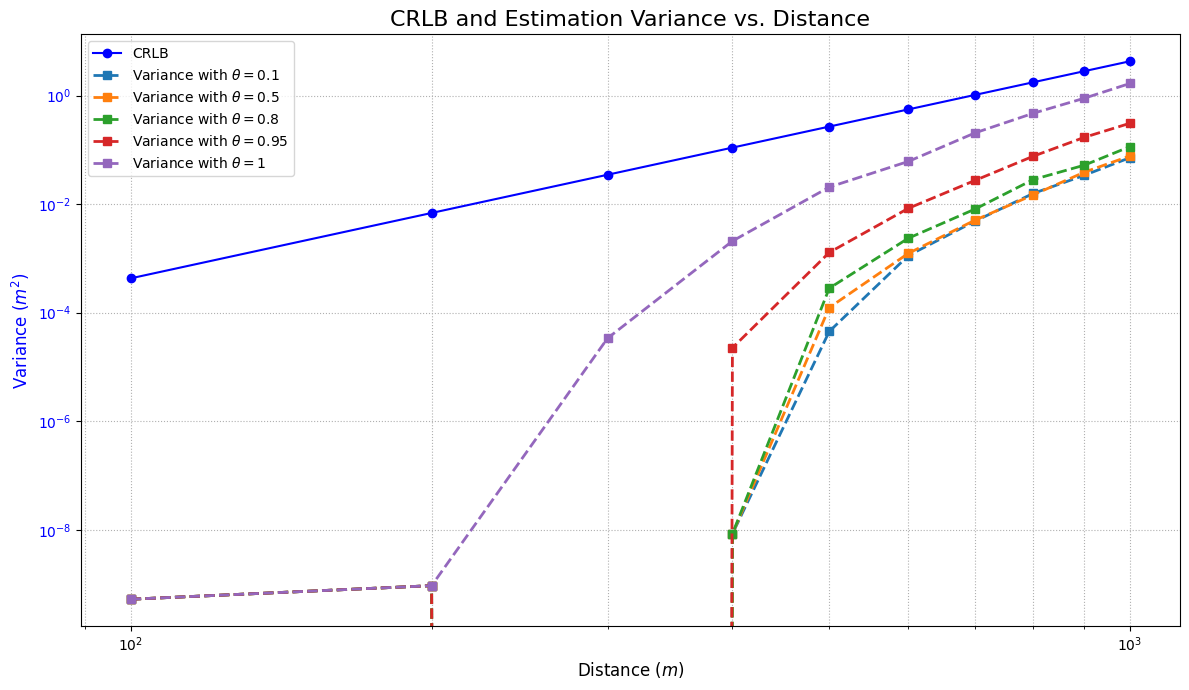

In [ ]:
d_idx = 9
d_bin_idx = torch.argmin(torch.abs(distances[d_idx] - est_distances[:, d_idx]))
out_of_bins_len = len(torch.nonzero(est_distances[:, d_idx] != est_distances[d_bin_idx, d_idx]))
probibility_of_success_detection_of_distance = (1 - out_of_bins_len / MN)*100
print(probibility_of_success_detection_of_distance)